In [66]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
from jaxopt import LBFGS
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import he_normal
from tqdm import tqdm

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
batch_size = 64
num_branches = 10
num_trunk_epochs = 120000
lr = 1e-5
num_LBFGS_epochs = 100000

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [67]:
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

In [68]:
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t']) ## REDUCE TIME WINDOW
x_grid = jnp.array(dataset['x'])
data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data])

# subselect time

s = s[:, -6:-1, :]
t_grid = t_grid[-6:-1]


n_samp = len(data)
train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.33, random_state = seed)
u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])


In [69]:
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)
print(xt_grid.shape)

ss_grid = s_train.reshape([-1, 1005]).T # adjust reshape index
#ss_grid = s_train.reshape([-1, 40401]).T # solutions
print(ss_grid.shape)

(1005, 2)
(1005, 295)


In [70]:
u_dim = 2 # in this case, two 
y_dim = 2 # (x,t)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_branches] 
trunk_arch  = [y_dim, 40, 40, num_branches] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (num_branches, s_train.shape[0]))

model = trunk_model, A_model

def deeponet_step1(model, u_tr):
    trunk_model, A_model = model
    trunk_mat = jax.vmap(trunk_model)(u_tr)
    return (trunk_mat @ A_model)

def loss_fn(model, u, s):
    pred_y = deeponet_step1(model,u)
    return jnp.mean((s - pred_y) ** 2) # sum of squared - to match svd interp

In [71]:
# equinox training step 
"""
@eqx.filter_jit
def train_step(model, opt_state, x, y, opt_update):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y) # get loss and gradients
    updates, opt_state = opt_update(grads, opt_state, model) # update step
    model = eqx.apply_updates(model, updates) # apply updates
    return model, opt_state, loss
"""


'\n@eqx.filter_jit\ndef train_step(model, opt_state, x, y, opt_update):\n    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y) # get loss and gradients\n    updates, opt_state = opt_update(grads, opt_state, model) # update step\n    model = eqx.apply_updates(model, updates) # apply updates\n    return model, opt_state, loss\n'

In [72]:
"""optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trunk_train_hist, trunk_test_hist = [],[]

print("beginning trunk training...")
for epoch in tqdm(range(num_trunk_epochs)):
    
    model, opt_state, loss = train_step(model, opt_state, xt_grid, ss_grid, optim.update)

    trunk_train_hist.append(float(loss))

save_path = "deeponet_trunk_model.eqx"
A_save_path = "A_model.npy"

eqx.tree_serialise_leaves(save_path, trunk_model)
np.save(A_save_path, np.array(A_model))

print(f"Saved trunk model to {save_path}")
print(f"Saved A_model to {A_save_path}")
"""

# 1. Pretrain with Adam
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

loss_hist = []

@eqx.filter_jit
def train_step(model, opt_state, batch):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, *batch)
    updates, opt_state = opt.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

for step in tqdm(range(num_trunk_epochs)):
    model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
    loss_hist.append(float(loss))
    if step % 1000 == 0:
        print(f"Adam step {step}: loss={float(loss):.3e}")

print("final adam loss:", loss)

opt = optax.lbfgs()

for step in tqdm(range(num_LBFGS_epochs)):
    model, opt_state, loss = train_step(model, opt_state, (xt_grid, ss_grid))
    loss_hist.append(float(loss))
    if step % 1000 == 0:
        print(f"LBFGS step {step}: loss={float(loss):.3e}")


  0%|          | 45/120000 [00:00<14:34, 137.23it/s] 

Adam step 0: loss=9.737e+00


  1%|          | 1036/120000 [00:03<05:21, 369.98it/s]

Adam step 1000: loss=3.470e+00


  2%|▏         | 2052/120000 [00:05<05:16, 372.70it/s]

Adam step 2000: loss=1.209e+00


  3%|▎         | 3069/120000 [00:08<05:42, 341.26it/s]

Adam step 3000: loss=4.884e-01


  3%|▎         | 4052/120000 [00:11<06:20, 305.07it/s]

Adam step 4000: loss=2.724e-01


  4%|▍         | 5070/120000 [00:14<05:31, 346.33it/s]

Adam step 5000: loss=2.071e-01


  5%|▌         | 6064/120000 [00:17<05:22, 353.59it/s]

Adam step 6000: loss=1.842e-01


  6%|▌         | 7029/120000 [00:20<06:25, 292.94it/s]

Adam step 7000: loss=1.735e-01


  7%|▋         | 8055/120000 [00:23<05:50, 319.48it/s]

Adam step 8000: loss=1.674e-01


  8%|▊         | 9042/120000 [00:26<05:59, 308.47it/s]

Adam step 9000: loss=1.627e-01


  8%|▊         | 10049/120000 [00:29<05:33, 329.34it/s]

Adam step 10000: loss=1.587e-01


  9%|▉         | 11054/120000 [00:32<05:16, 344.36it/s]

Adam step 11000: loss=1.551e-01


 10%|█         | 12043/120000 [00:35<05:01, 358.40it/s]

Adam step 12000: loss=1.519e-01


 11%|█         | 13065/120000 [00:38<04:50, 368.69it/s]

Adam step 13000: loss=1.490e-01


 12%|█▏        | 14040/120000 [00:41<04:54, 360.40it/s]

Adam step 14000: loss=1.462e-01


 13%|█▎        | 15051/120000 [00:44<06:04, 287.54it/s]

Adam step 15000: loss=1.433e-01


 13%|█▎        | 16042/120000 [00:47<05:11, 334.14it/s]

Adam step 16000: loss=1.402e-01


 14%|█▍        | 17055/120000 [00:50<04:42, 364.39it/s]

Adam step 17000: loss=1.369e-01


 15%|█▌        | 18061/120000 [00:53<05:04, 334.38it/s]

Adam step 18000: loss=1.333e-01


 16%|█▌        | 19055/120000 [00:55<04:48, 350.09it/s]

Adam step 19000: loss=1.295e-01


 17%|█▋        | 20068/120000 [00:58<04:32, 366.44it/s]

Adam step 20000: loss=1.258e-01


 18%|█▊        | 21068/120000 [01:01<04:33, 362.12it/s]

Adam step 21000: loss=1.222e-01


 18%|█▊        | 22042/120000 [01:04<04:33, 357.83it/s]

Adam step 22000: loss=1.185e-01


 19%|█▉        | 23036/120000 [01:06<04:44, 341.20it/s]

Adam step 23000: loss=1.149e-01


 20%|██        | 24063/120000 [01:10<04:32, 351.71it/s]

Adam step 24000: loss=1.112e-01


 21%|██        | 25063/120000 [01:12<04:08, 381.62it/s]

Adam step 25000: loss=1.075e-01


 22%|██▏       | 26062/120000 [01:15<04:11, 374.07it/s]

Adam step 26000: loss=1.038e-01


 23%|██▎       | 27063/120000 [01:18<04:05, 379.23it/s]

Adam step 27000: loss=1.001e-01


 23%|██▎       | 28042/120000 [01:20<04:09, 368.69it/s]

Adam step 28000: loss=9.648e-02


 24%|██▍       | 29042/120000 [01:23<03:58, 381.09it/s]

Adam step 29000: loss=9.284e-02


 25%|██▌       | 30073/120000 [01:26<03:59, 375.98it/s]

Adam step 30000: loss=8.921e-02


 26%|██▌       | 31062/120000 [01:28<04:05, 362.04it/s]

Adam step 31000: loss=8.561e-02


 27%|██▋       | 32055/120000 [01:31<04:00, 366.32it/s]

Adam step 32000: loss=8.203e-02


 28%|██▊       | 33049/120000 [01:34<03:57, 366.53it/s]

Adam step 33000: loss=7.850e-02


 28%|██▊       | 34049/120000 [01:36<03:47, 378.59it/s]

Adam step 34000: loss=7.501e-02


 29%|██▉       | 35044/120000 [01:39<03:44, 378.26it/s]

Adam step 35000: loss=7.158e-02


 30%|███       | 36045/120000 [01:42<03:47, 368.56it/s]

Adam step 36000: loss=6.820e-02


 31%|███       | 37040/120000 [01:44<03:43, 370.86it/s]

Adam step 37000: loss=6.489e-02


 32%|███▏      | 38062/120000 [01:47<03:48, 358.98it/s]

Adam step 38000: loss=6.166e-02


 33%|███▎      | 39040/120000 [01:50<04:10, 322.56it/s]

Adam step 39000: loss=5.849e-02


 33%|███▎      | 40047/120000 [01:53<03:47, 352.04it/s]

Adam step 40000: loss=5.540e-02


 34%|███▍      | 41049/120000 [01:56<03:32, 371.97it/s]

Adam step 41000: loss=5.239e-02


 35%|███▌      | 42069/120000 [01:59<03:37, 358.43it/s]

Adam step 42000: loss=4.947e-02


 36%|███▌      | 43045/120000 [02:02<04:06, 312.46it/s]

Adam step 43000: loss=4.664e-02


 37%|███▋      | 44050/120000 [02:05<04:19, 292.22it/s]

Adam step 44000: loss=4.391e-02


 38%|███▊      | 45046/120000 [02:08<03:37, 344.87it/s]

Adam step 45000: loss=4.128e-02


 38%|███▊      | 46041/120000 [02:11<03:55, 313.86it/s]

Adam step 46000: loss=3.875e-02


 39%|███▉      | 47047/120000 [02:13<03:17, 369.59it/s]

Adam step 47000: loss=3.632e-02


 40%|████      | 48055/120000 [02:16<03:17, 364.77it/s]

Adam step 48000: loss=3.399e-02


 41%|████      | 49058/120000 [02:19<03:07, 377.91it/s]

Adam step 49000: loss=3.175e-02


 42%|████▏     | 50051/120000 [02:22<03:07, 372.19it/s]

Adam step 50000: loss=2.960e-02


 43%|████▎     | 51047/120000 [02:24<03:03, 374.84it/s]

Adam step 51000: loss=2.753e-02


 43%|████▎     | 52040/120000 [02:27<03:14, 349.86it/s]

Adam step 52000: loss=2.556e-02


 44%|████▍     | 53069/120000 [02:30<03:03, 365.04it/s]

Adam step 53000: loss=2.367e-02


 45%|████▌     | 54062/120000 [02:32<02:56, 374.29it/s]

Adam step 54000: loss=2.187e-02


 46%|████▌     | 55047/120000 [02:35<03:08, 345.32it/s]

Adam step 55000: loss=2.015e-02


 47%|████▋     | 56039/120000 [02:38<02:51, 373.02it/s]

Adam step 56000: loss=1.852e-02


 48%|████▊     | 57071/120000 [02:40<02:48, 373.15it/s]

Adam step 57000: loss=1.698e-02


 48%|████▊     | 58069/120000 [02:43<02:45, 373.19it/s]

Adam step 58000: loss=1.553e-02


 49%|████▉     | 59054/120000 [02:46<02:41, 378.39it/s]

Adam step 59000: loss=1.417e-02


 50%|█████     | 60044/120000 [02:48<02:40, 374.31it/s]

Adam step 60000: loss=1.289e-02


 51%|█████     | 61073/120000 [02:51<02:40, 366.53it/s]

Adam step 61000: loss=1.170e-02


 52%|█████▏    | 62059/120000 [02:54<02:32, 378.82it/s]

Adam step 62000: loss=1.060e-02


 53%|█████▎    | 63059/120000 [02:57<02:31, 375.85it/s]

Adam step 63000: loss=9.574e-03


 53%|█████▎    | 64052/120000 [02:59<02:31, 368.51it/s]

Adam step 64000: loss=8.630e-03


 54%|█████▍    | 65063/120000 [03:02<02:29, 368.07it/s]

Adam step 65000: loss=7.761e-03


 55%|█████▌    | 66071/120000 [03:05<02:28, 363.85it/s]

Adam step 66000: loss=6.967e-03


 56%|█████▌    | 67051/120000 [03:08<02:22, 370.77it/s]

Adam step 67000: loss=6.245e-03


 57%|█████▋    | 68065/120000 [03:11<02:28, 350.46it/s]

Adam step 68000: loss=5.591e-03


 58%|█████▊    | 69034/120000 [03:13<02:40, 317.82it/s]

Adam step 69000: loss=4.999e-03


 58%|█████▊    | 70067/120000 [03:16<02:14, 371.35it/s]

Adam step 70000: loss=4.464e-03


 59%|█████▉    | 71053/120000 [03:19<02:21, 345.40it/s]

Adam step 71000: loss=3.980e-03


 60%|██████    | 72039/120000 [03:22<02:10, 366.35it/s]

Adam step 72000: loss=3.542e-03


 61%|██████    | 73071/120000 [03:25<02:06, 372.39it/s]

Adam step 73000: loss=3.145e-03


 62%|██████▏   | 74069/120000 [03:27<02:07, 359.93it/s]

Adam step 74000: loss=2.785e-03


 63%|██████▎   | 75048/120000 [03:30<01:59, 376.40it/s]

Adam step 75000: loss=2.456e-03


 63%|██████▎   | 76042/120000 [03:33<02:00, 365.95it/s]

Adam step 76000: loss=2.153e-03


 64%|██████▍   | 77064/120000 [03:35<01:54, 374.18it/s]

Adam step 77000: loss=1.877e-03


 65%|██████▌   | 78069/120000 [03:38<02:03, 338.56it/s]

Adam step 78000: loss=1.628e-03


 66%|██████▌   | 79047/120000 [03:41<02:03, 332.43it/s]

Adam step 79000: loss=1.407e-03


 67%|██████▋   | 80050/120000 [03:44<01:50, 361.94it/s]

Adam step 80000: loss=1.213e-03


 68%|██████▊   | 81060/120000 [03:47<01:45, 367.43it/s]

Adam step 81000: loss=1.045e-03


 68%|██████▊   | 82038/120000 [03:49<01:51, 339.49it/s]

Adam step 82000: loss=9.027e-04


 69%|██████▉   | 83059/120000 [03:52<01:41, 363.22it/s]

Adam step 83000: loss=7.857e-04


 70%|███████   | 84066/120000 [03:55<01:39, 360.67it/s]

Adam step 84000: loss=6.911e-04


 71%|███████   | 85072/120000 [03:58<01:33, 373.54it/s]

Adam step 85000: loss=6.157e-04


 72%|███████▏  | 86055/120000 [04:00<01:32, 365.66it/s]

Adam step 86000: loss=5.564e-04


 73%|███████▎  | 87038/120000 [04:03<01:32, 357.66it/s]

Adam step 87000: loss=5.117e-04


 73%|███████▎  | 88052/120000 [04:06<01:35, 334.21it/s]

Adam step 88000: loss=4.806e-04


 74%|███████▍  | 89064/120000 [04:09<01:23, 370.23it/s]

Adam step 89000: loss=4.612e-04


 75%|███████▌  | 90061/120000 [04:11<01:21, 367.66it/s]

Adam step 90000: loss=4.497e-04


 76%|███████▌  | 91050/120000 [04:14<01:18, 370.32it/s]

Adam step 91000: loss=4.415e-04


 77%|███████▋  | 92076/120000 [04:17<01:14, 373.94it/s]

Adam step 92000: loss=4.342e-04


 78%|███████▊  | 93051/120000 [04:20<01:14, 359.58it/s]

Adam step 93000: loss=4.269e-04


 78%|███████▊  | 94063/120000 [04:22<01:17, 334.71it/s]

Adam step 94000: loss=4.196e-04


 79%|███████▉  | 95035/120000 [04:25<01:11, 349.01it/s]

Adam step 95000: loss=4.121e-04


 80%|████████  | 96037/120000 [04:28<01:06, 359.73it/s]

Adam step 96000: loss=4.043e-04


 81%|████████  | 97031/120000 [04:31<01:11, 322.64it/s]

Adam step 97000: loss=3.965e-04


 82%|████████▏ | 98073/120000 [04:34<00:58, 372.45it/s]

Adam step 98000: loss=3.887e-04


 83%|████████▎ | 99047/120000 [04:36<00:59, 351.34it/s]

Adam step 99000: loss=3.809e-04


 83%|████████▎ | 100045/120000 [04:39<00:54, 363.59it/s]

Adam step 100000: loss=3.731e-04


 84%|████████▍ | 101062/120000 [04:42<00:50, 372.19it/s]

Adam step 101000: loss=3.652e-04


 85%|████████▌ | 102048/120000 [04:44<00:47, 376.48it/s]

Adam step 102000: loss=3.572e-04


 86%|████████▌ | 103046/120000 [04:47<00:44, 379.81it/s]

Adam step 103000: loss=3.494e-04


 87%|████████▋ | 104043/120000 [04:50<00:42, 372.89it/s]

Adam step 104000: loss=3.415e-04


 88%|████████▊ | 105061/120000 [04:53<00:40, 365.30it/s]

Adam step 105000: loss=3.337e-04


 88%|████████▊ | 106063/120000 [04:55<00:39, 357.07it/s]

Adam step 106000: loss=3.259e-04


 89%|████████▉ | 107051/120000 [04:58<00:36, 351.42it/s]

Adam step 107000: loss=3.181e-04


 90%|█████████ | 108071/120000 [05:01<00:32, 367.90it/s]

Adam step 108000: loss=3.104e-04


 91%|█████████ | 109062/120000 [05:04<00:30, 355.30it/s]

Adam step 109000: loss=3.028e-04


 92%|█████████▏| 110046/120000 [05:07<00:28, 348.55it/s]

Adam step 110000: loss=2.952e-04


 93%|█████████▎| 111058/120000 [05:09<00:24, 368.82it/s]

Adam step 111000: loss=2.876e-04


 93%|█████████▎| 112044/120000 [05:12<00:21, 372.96it/s]

Adam step 112000: loss=2.802e-04


 94%|█████████▍| 113075/120000 [05:15<00:18, 372.45it/s]

Adam step 113000: loss=2.729e-04


 95%|█████████▌| 114048/120000 [05:18<00:16, 350.73it/s]

Adam step 114000: loss=2.657e-04


 96%|█████████▌| 115067/120000 [05:20<00:13, 365.32it/s]

Adam step 115000: loss=2.585e-04


 97%|█████████▋| 116069/120000 [05:23<00:11, 353.56it/s]

Adam step 116000: loss=2.513e-04


 98%|█████████▊| 117075/120000 [05:26<00:07, 376.80it/s]

Adam step 117000: loss=2.440e-04


 98%|█████████▊| 118068/120000 [05:29<00:05, 352.67it/s]

Adam step 118000: loss=2.365e-04


 99%|█████████▉| 119038/120000 [05:31<00:02, 361.19it/s]

Adam step 119000: loss=2.292e-04


100%|██████████| 120000/120000 [05:34<00:00, 358.80it/s]


final adam loss: 0.00022249387


  0%|          | 40/100000 [00:00<04:15, 391.16it/s]

LBFGS step 0: loss=2.225e-04


  1%|          | 1038/100000 [00:02<04:25, 372.60it/s]

LBFGS step 1000: loss=2.161e-04


  2%|▏         | 2062/100000 [00:05<04:24, 369.89it/s]

LBFGS step 2000: loss=2.099e-04


  3%|▎         | 3052/100000 [00:08<04:45, 339.91it/s]

LBFGS step 3000: loss=2.040e-04


  4%|▍         | 4057/100000 [00:11<04:20, 367.92it/s]

LBFGS step 4000: loss=1.983e-04


  5%|▌         | 5047/100000 [00:13<04:16, 370.24it/s]

LBFGS step 5000: loss=1.927e-04


  6%|▌         | 6047/100000 [00:16<04:22, 357.68it/s]

LBFGS step 6000: loss=1.873e-04


  7%|▋         | 7075/100000 [00:19<04:11, 369.70it/s]

LBFGS step 7000: loss=1.821e-04


  8%|▊         | 8057/100000 [00:22<04:18, 355.91it/s]

LBFGS step 8000: loss=1.770e-04


  9%|▉         | 9049/100000 [00:24<04:08, 365.91it/s]

LBFGS step 9000: loss=1.720e-04


 10%|█         | 10068/100000 [00:27<04:05, 366.85it/s]

LBFGS step 10000: loss=1.673e-04


 11%|█         | 11061/100000 [00:30<04:01, 368.94it/s]

LBFGS step 11000: loss=1.627e-04


 12%|█▏        | 12047/100000 [00:32<03:52, 377.78it/s]

LBFGS step 12000: loss=1.582e-04


 13%|█▎        | 13043/100000 [00:35<03:52, 374.58it/s]

LBFGS step 13000: loss=1.539e-04


 14%|█▍        | 14039/100000 [00:38<03:54, 366.79it/s]

LBFGS step 14000: loss=1.497e-04


 15%|█▌        | 15055/100000 [00:41<04:12, 335.97it/s]

LBFGS step 15000: loss=1.457e-04


 16%|█▌        | 16038/100000 [00:44<03:45, 372.78it/s]

LBFGS step 16000: loss=1.418e-04


 17%|█▋        | 17060/100000 [00:46<03:44, 370.10it/s]

LBFGS step 17000: loss=1.380e-04


 18%|█▊        | 18071/100000 [00:49<03:36, 377.97it/s]

LBFGS step 18000: loss=1.344e-04


 19%|█▉        | 19062/100000 [00:52<03:42, 363.15it/s]

LBFGS step 19000: loss=1.308e-04


 20%|██        | 20043/100000 [00:54<03:40, 362.45it/s]

LBFGS step 20000: loss=1.275e-04


 21%|██        | 21072/100000 [00:57<03:31, 372.65it/s]

LBFGS step 21000: loss=1.242e-04


 22%|██▏       | 22049/100000 [01:00<03:31, 369.37it/s]

LBFGS step 22000: loss=1.210e-04


 23%|██▎       | 23043/100000 [01:03<03:26, 372.50it/s]

LBFGS step 23000: loss=1.180e-04


 24%|██▍       | 24038/100000 [01:05<03:30, 361.26it/s]

LBFGS step 24000: loss=1.150e-04


 25%|██▌       | 25055/100000 [01:08<03:28, 358.86it/s]

LBFGS step 25000: loss=1.122e-04


 26%|██▌       | 26041/100000 [01:11<03:19, 370.45it/s]

LBFGS step 26000: loss=1.095e-04


 27%|██▋       | 27070/100000 [01:14<03:14, 374.66it/s]

LBFGS step 27000: loss=1.069e-04


 28%|██▊       | 28062/100000 [01:16<03:18, 361.99it/s]

LBFGS step 28000: loss=1.043e-04


 29%|██▉       | 29052/100000 [01:19<03:08, 377.02it/s]

LBFGS step 29000: loss=1.019e-04


 30%|███       | 30044/100000 [01:22<03:04, 379.32it/s]

LBFGS step 30000: loss=9.957e-05


 31%|███       | 31065/100000 [01:25<03:09, 362.98it/s]

LBFGS step 31000: loss=9.730e-05


 32%|███▏      | 32043/100000 [01:27<03:03, 370.61it/s]

LBFGS step 32000: loss=9.513e-05


 33%|███▎      | 33044/100000 [01:30<02:58, 374.52it/s]

LBFGS step 33000: loss=9.304e-05


 34%|███▍      | 34055/100000 [01:33<03:03, 360.13it/s]

LBFGS step 34000: loss=9.103e-05


 35%|███▌      | 35045/100000 [01:35<02:58, 364.56it/s]

LBFGS step 35000: loss=8.909e-05


 36%|███▌      | 36046/100000 [01:38<02:49, 377.01it/s]

LBFGS step 36000: loss=8.722e-05


 37%|███▋      | 37043/100000 [01:41<02:50, 369.20it/s]

LBFGS step 37000: loss=8.542e-05


 38%|███▊      | 38042/100000 [01:44<02:45, 373.42it/s]

LBFGS step 38000: loss=8.366e-05


 39%|███▉      | 39064/100000 [01:46<02:56, 346.16it/s]

LBFGS step 39000: loss=8.196e-05


 40%|████      | 40048/100000 [01:49<02:47, 358.65it/s]

LBFGS step 40000: loss=8.033e-05


 41%|████      | 41043/100000 [01:52<02:40, 367.65it/s]

LBFGS step 41000: loss=7.874e-05


 42%|████▏     | 42062/100000 [01:55<02:37, 368.57it/s]

LBFGS step 42000: loss=7.720e-05


 43%|████▎     | 43050/100000 [01:57<02:33, 372.21it/s]

LBFGS step 43000: loss=7.571e-05


 44%|████▍     | 44070/100000 [02:00<02:35, 360.81it/s]

LBFGS step 44000: loss=7.427e-05


 45%|████▌     | 45059/100000 [02:03<02:31, 362.94it/s]

LBFGS step 45000: loss=7.287e-05


 46%|████▌     | 46047/100000 [02:05<02:27, 366.69it/s]

LBFGS step 46000: loss=7.152e-05


 47%|████▋     | 47037/100000 [02:08<02:27, 359.19it/s]

LBFGS step 47000: loss=7.020e-05


 48%|████▊     | 48062/100000 [02:11<02:20, 370.62it/s]

LBFGS step 48000: loss=6.893e-05


 49%|████▉     | 49059/100000 [02:13<02:16, 373.69it/s]

LBFGS step 49000: loss=6.768e-05


 50%|█████     | 50043/100000 [02:16<02:20, 355.82it/s]

LBFGS step 50000: loss=6.648e-05


 51%|█████     | 51062/100000 [02:19<02:14, 363.90it/s]

LBFGS step 51000: loss=6.531e-05


 52%|█████▏    | 52045/100000 [02:22<02:08, 372.55it/s]

LBFGS step 52000: loss=6.417e-05


 53%|█████▎    | 53074/100000 [02:24<02:07, 367.64it/s]

LBFGS step 53000: loss=6.307e-05


 54%|█████▍    | 54053/100000 [02:27<02:03, 370.99it/s]

LBFGS step 54000: loss=6.199e-05


 55%|█████▌    | 55043/100000 [02:30<02:04, 359.96it/s]

LBFGS step 55000: loss=6.095e-05


 56%|█████▌    | 56073/100000 [02:33<01:57, 373.76it/s]

LBFGS step 56000: loss=5.992e-05


 57%|█████▋    | 57070/100000 [02:35<01:56, 367.75it/s]

LBFGS step 57000: loss=5.892e-05


 58%|█████▊    | 58072/100000 [02:38<01:50, 379.57it/s]

LBFGS step 58000: loss=5.795e-05


 59%|█████▉    | 59063/100000 [02:41<01:51, 365.79it/s]

LBFGS step 59000: loss=5.701e-05


 60%|██████    | 60059/100000 [02:43<01:45, 378.46it/s]

LBFGS step 60000: loss=5.608e-05


 61%|██████    | 61037/100000 [02:46<01:48, 358.34it/s]

LBFGS step 61000: loss=5.519e-05


 62%|██████▏   | 62061/100000 [02:49<01:46, 357.03it/s]

LBFGS step 62000: loss=5.432e-05


 63%|██████▎   | 63040/100000 [02:51<01:39, 371.92it/s]

LBFGS step 63000: loss=5.346e-05


 64%|██████▍   | 64040/100000 [02:54<01:33, 383.30it/s]

LBFGS step 64000: loss=5.263e-05


 65%|██████▌   | 65069/100000 [02:57<01:33, 372.78it/s]

LBFGS step 65000: loss=5.182e-05


 66%|██████▌   | 66066/100000 [03:00<01:33, 362.09it/s]

LBFGS step 66000: loss=5.102e-05


 67%|██████▋   | 67038/100000 [03:03<01:36, 342.13it/s]

LBFGS step 67000: loss=5.024e-05


 68%|██████▊   | 68041/100000 [03:06<01:49, 292.83it/s]

LBFGS step 68000: loss=4.947e-05


 69%|██████▉   | 69049/100000 [03:09<01:29, 345.10it/s]

LBFGS step 69000: loss=4.873e-05


 70%|███████   | 70050/100000 [03:11<01:32, 324.46it/s]

LBFGS step 70000: loss=4.803e-05


 71%|███████   | 71070/100000 [03:14<01:20, 359.85it/s]

LBFGS step 71000: loss=4.733e-05


 72%|███████▏  | 72072/100000 [03:17<01:18, 355.16it/s]

LBFGS step 72000: loss=4.666e-05


 73%|███████▎  | 73038/100000 [03:20<01:15, 356.57it/s]

LBFGS step 73000: loss=4.601e-05


 74%|███████▍  | 74048/100000 [03:23<01:10, 369.52it/s]

LBFGS step 74000: loss=4.538e-05


 75%|███████▌  | 75066/100000 [03:26<01:07, 368.67it/s]

LBFGS step 75000: loss=4.476e-05


 76%|███████▌  | 76040/100000 [03:28<01:05, 365.30it/s]

LBFGS step 76000: loss=4.417e-05


 77%|███████▋  | 77056/100000 [03:31<01:02, 370.03it/s]

LBFGS step 77000: loss=4.359e-05


 78%|███████▊  | 78040/100000 [03:34<00:59, 369.51it/s]

LBFGS step 78000: loss=4.303e-05


 79%|███████▉  | 79054/100000 [03:37<01:00, 346.77it/s]

LBFGS step 79000: loss=4.250e-05


 80%|████████  | 80076/100000 [03:39<00:54, 365.95it/s]

LBFGS step 80000: loss=4.195e-05


 81%|████████  | 81056/100000 [03:42<00:51, 370.02it/s]

LBFGS step 81000: loss=4.146e-05


 82%|████████▏ | 82054/100000 [03:45<00:56, 319.79it/s]

LBFGS step 82000: loss=4.094e-05


 83%|████████▎ | 83067/100000 [03:48<00:44, 377.84it/s]

LBFGS step 83000: loss=4.046e-05


 84%|████████▍ | 84067/100000 [03:51<00:43, 364.10it/s]

LBFGS step 84000: loss=3.999e-05


 85%|████████▌ | 85061/100000 [03:53<00:40, 370.85it/s]

LBFGS step 85000: loss=3.953e-05


 86%|████████▌ | 86048/100000 [03:56<00:37, 375.84it/s]

LBFGS step 86000: loss=3.909e-05


 87%|████████▋ | 87053/100000 [03:59<00:39, 325.79it/s]

LBFGS step 87000: loss=3.866e-05


 88%|████████▊ | 88070/100000 [04:02<00:33, 359.70it/s]

LBFGS step 88000: loss=3.825e-05


 89%|████████▉ | 89049/100000 [04:05<00:30, 363.43it/s]

LBFGS step 89000: loss=3.784e-05


 90%|█████████ | 90062/100000 [04:07<00:27, 367.33it/s]

LBFGS step 90000: loss=3.746e-05


 91%|█████████ | 91063/100000 [04:10<00:24, 369.97it/s]

LBFGS step 91000: loss=3.708e-05


 92%|█████████▏| 92044/100000 [04:13<00:21, 368.28it/s]

LBFGS step 92000: loss=3.672e-05


 93%|█████████▎| 93047/100000 [04:16<00:21, 316.50it/s]

LBFGS step 93000: loss=3.636e-05


 94%|█████████▍| 94036/100000 [04:19<00:17, 347.67it/s]

LBFGS step 94000: loss=3.602e-05


 95%|█████████▌| 95069/100000 [04:21<00:13, 372.87it/s]

LBFGS step 95000: loss=3.568e-05


 96%|█████████▌| 96037/100000 [04:24<00:10, 364.66it/s]

LBFGS step 96000: loss=3.536e-05


 97%|█████████▋| 97042/100000 [04:27<00:08, 352.99it/s]

LBFGS step 97000: loss=3.507e-05


 98%|█████████▊| 98044/100000 [04:30<00:05, 352.91it/s]

LBFGS step 98000: loss=3.475e-05


 99%|█████████▉| 99074/100000 [04:33<00:02, 366.34it/s]

LBFGS step 99000: loss=3.446e-05


100%|██████████| 100000/100000 [04:35<00:00, 362.83it/s]



Final training loss after L-BFGS: 3.417426e-05


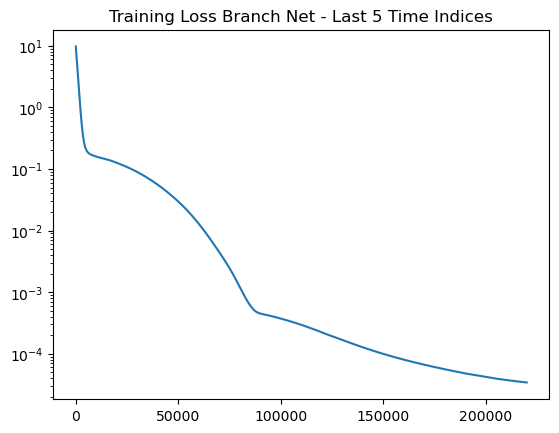

In [73]:
# Evaluate final loss on training data
final_loss = float(loss_fn(model, xt_grid, ss_grid))
print(f"\nFinal training loss after L-BFGS: {final_loss:.6e}")

plt.plot(loss_hist)
plt.title("Training Loss Branch Net - Last 5 Time Indices")
plt.yscale('log')

In [74]:
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid)) # this is against the entire flattened xt grid - not at fixed time t
Q,R = scipy.linalg.qr(trunk_mat, mode = 'economic')
T = scipy.linalg.inv(R.T)


In [75]:
xx, tt = jnp.meshgrid(x_grid,t_grid[-1:])
xt_grid_at_i = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)

In [76]:
trunk_mat_at_i = np.array(jax.vmap(trunk_model)(xt_grid_at_i))
Q,R = scipy.linalg.qr(trunk_mat_at_i, mode = 'economic')

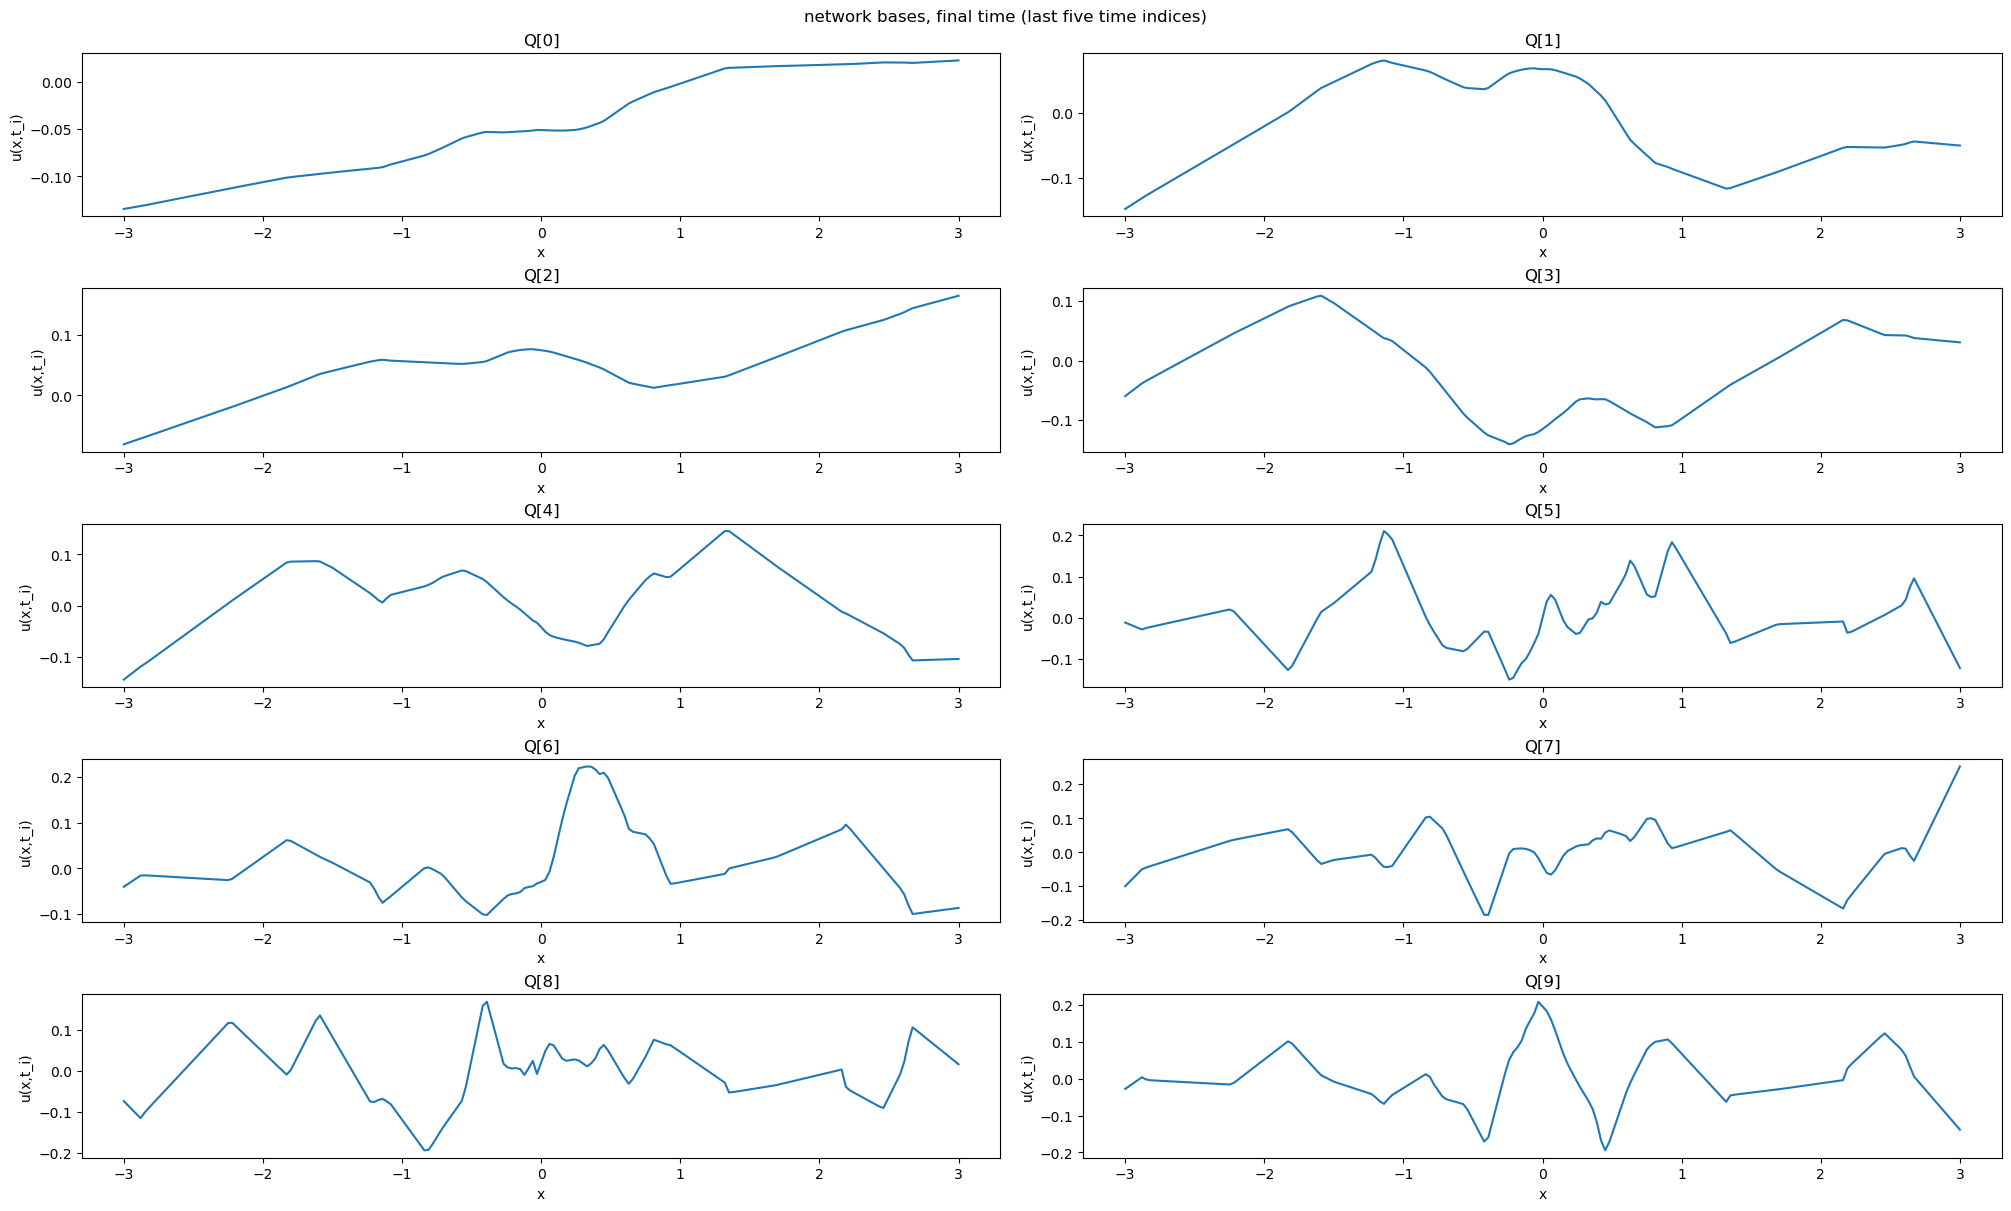

In [77]:
num_funcs = trunk_mat_at_i.shape[-1]
fig, axes = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        ax.plot(x_grid, Q[:,k])
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x,t_i)")
# plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
fig.suptitle("network bases, final time (last five time indices)")
plt.show()



In [78]:
Nt, Nx = len(t_grid), len(x_grid)
num_funcs = trunk_model(jnp.array([x_grid[0], t_grid[0]])).shape[-1]
Q_list = []

## REPLACE WITH SVD ORTHOGONALIZATION

for i, t in enumerate(t_grid):
    xx = jnp.stack([x_grid, jnp.full_like(x_grid, t)], axis=1)
    trunk_mat_t = np.array(jax.vmap(trunk_model)(xx))  # (Nx, num_funcs)
    Q_t, R_t = scipy.linalg.qr(trunk_mat_t, mode='economic')
    Q_list.append(Q_t)

Q_array = np.stack(Q_list, axis=0)  # shape (Nt, Nx, num_funcs)


In [79]:
len(Q_list)

5

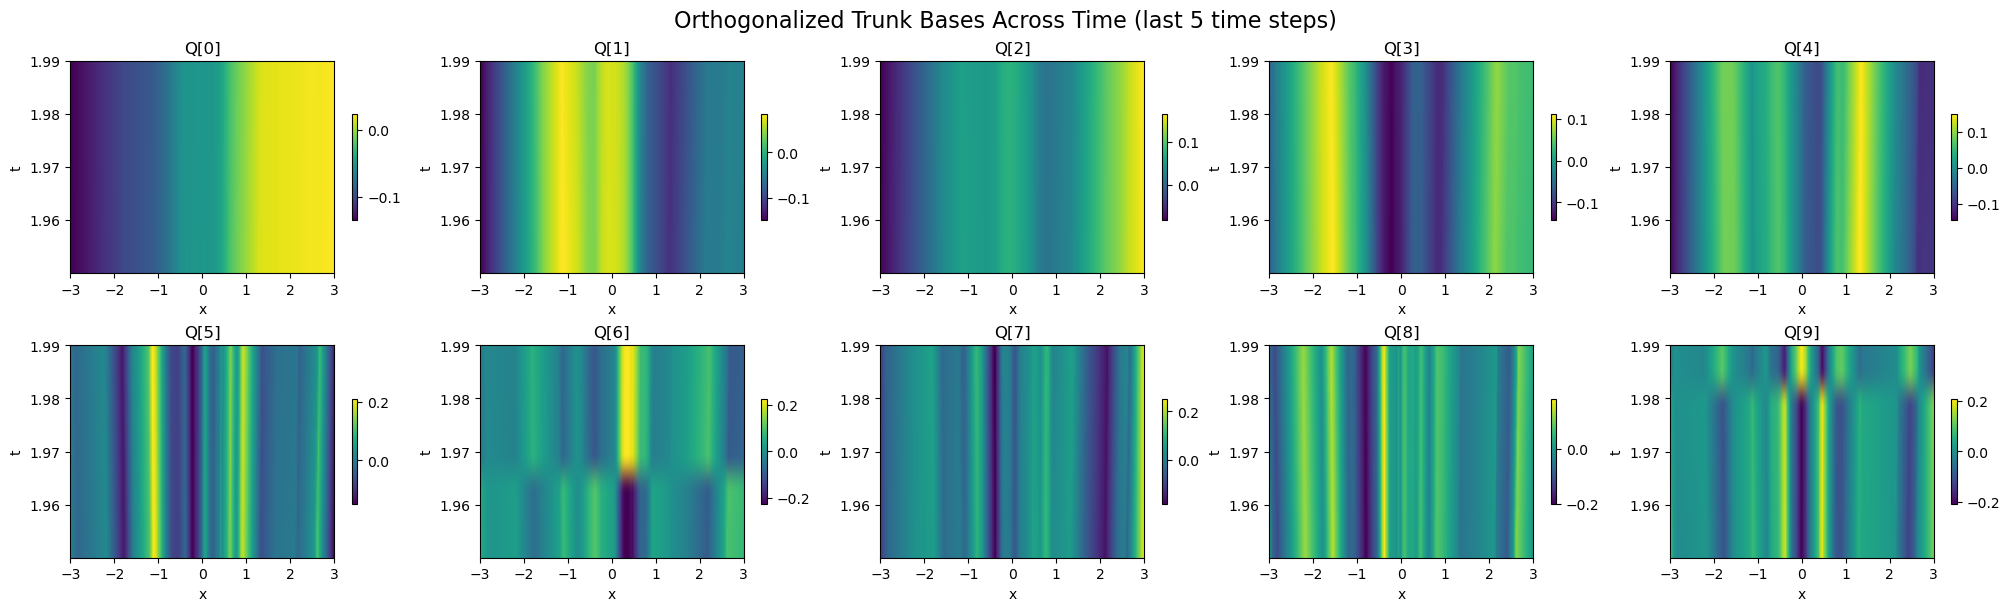

In [80]:

# choose subplot layout automatically (or manually override)
ncols = 5
nrows = int(np.ceil(num_funcs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows), constrained_layout=True)

# flatten axes array for easy indexing
axes = axes.flatten()

for k, ax in enumerate(axes):
    if k < num_funcs:
        im = ax.imshow(
            Q_array[:, :, k],
            extent=(x_grid.min(), x_grid.max(), t_grid.min(), t_grid.max()),
            origin="lower",
            aspect="auto",
            cmap="viridis",
        )
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
        fig.colorbar(im, ax=ax, fraction=0.02)
    else:
        ax.axis("off")

fig.suptitle("Orthogonalized Trunk Bases Across Time (last 5 time steps)", fontsize=16)
plt.show()


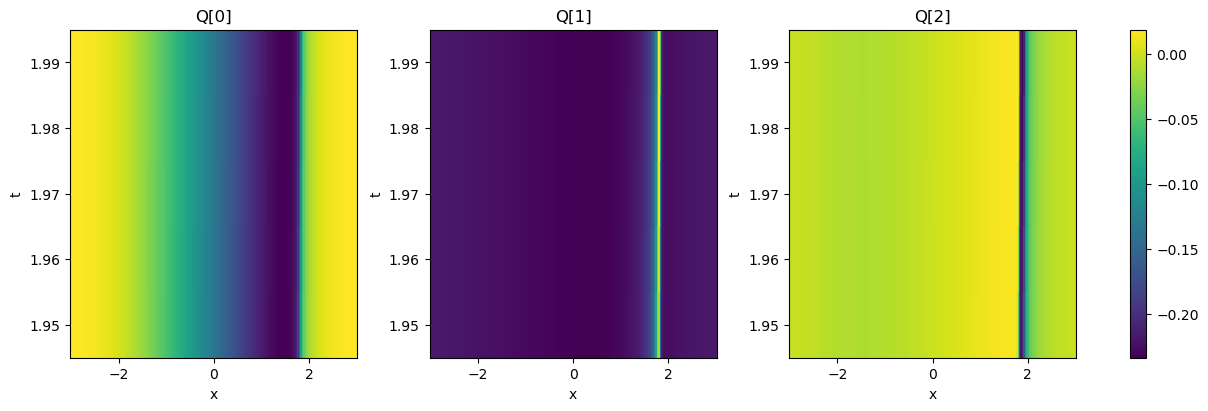

In [81]:
n_t, n_x = len(t_grid), len(x_grid)
Q,R = scipy.linalg.qr(ss_grid, mode = 'economic')
orth_funcs = Q.reshape(n_t, n_x, -1)
num_funcs = 3

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()



## block orthogonalization (multiple time inc)

## SVD Based Method

In [82]:
# calculate SVD of ss_grid (known solutions on domain)
U, s, Vh = scipy.linalg.svd(ss_grid)

In [83]:
errs = []
for truncated_rank in tqdm(np.arange(1, s.shape[0] + 1)):
    err = np.mean((ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])))**2)
    errs.append(err)



  0%|          | 0/295 [00:00<?, ?it/s]

100%|██████████| 295/295 [00:02<00:00, 120.57it/s]


Text(0, 0.5, 'MSE')

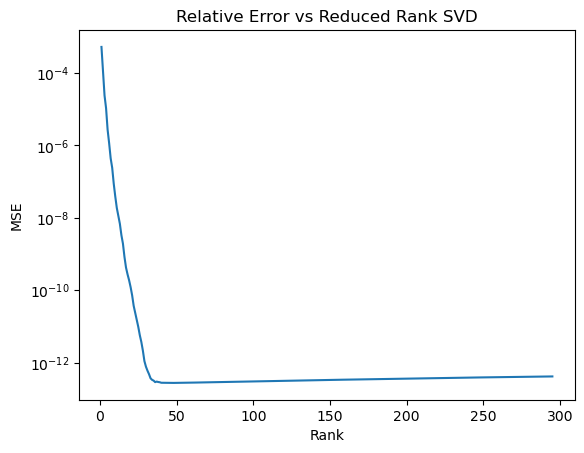

In [84]:
plt.semilogy(np.arange(1, s.shape[0] + 1), errs)
plt.title("Relative Error vs Reduced Rank SVD")
plt.xlabel("Rank")
plt.ylabel("MSE")

In [85]:
truncated_rank = 20
# err = np.linalg.norm(ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])) )
err = np.mean((ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])))**2)
print(f"err={err:.4e}")

err=1.2232e-10


In [86]:
deepOnet_err = np.mean(ss_grid - deeponet_step1(model, xt_grid))
print(f"deepOnet_err={deepOnet_err:.4e}")

deepOnet_err=-5.1368e-06


In [87]:
# s.shape
len(np.where(s > 1e-4)[0])

34